In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import librosa as lr
import pickle
import matplotlib.pyplot as plt

from pypesq import pesq
from pesq import pesq as pesq2
from pystoi.stoi import stoi as pystoi_stoi
from pathlib import PurePath
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def read_audio(path, target_fs=None):
    (audio, fs) = sf.read(path)
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    if target_fs is not None and fs != target_fs:
        audio = lr.resample(audio, orig_sr=fs, target_sr=target_fs)
        fs = target_fs
    return audio, fs

def all_file_paths(root_dir):
    return [os.path.join(root, name)
            for root, dirs, files in os.walk(root_dir)
            for name in files]


def calculate_pesq(workspace, speech_dir, model_name, te_snr,
                   library='pypesq', mode='nb', calc_mixed=False, force=False):
    """Calculate PESQ of all enhaced speech.

    Args:
      workspace: str, path of workspace.
      speech_dir: str, path of clean speech.
      te_snr: float, testing SNR.
    """
    assert library in ('pypesq', 'pesq', 'stoi')
    assert mode in ('wb', 'nb')
    
    if library == 'pypesq':
        results_file = os.path.join(workspace, 'evaluation', f'pesq_results_{model_name}.csv')
    elif library == 'pesq':
        results_file = os.path.join(workspace, 'evaluation', f'pesq2_results_{mode}_{model_name}.csv')
    else:
        results_file = os.path.join(workspace, 'evaluation', f'stoi_results_{model_name}.csv')
        
    if os.path.isfile(results_file) and not force:
        print('PESQ is already calculated')
        return pd.read_csv(results_file)
    
    df = pd.DataFrame(columns=['filepath', 'snr', 'pesq'])
    speech_audio_cache = {}
    
    os.makedirs(os.path.dirname(results_file), exist_ok=True)
        
    for snr in te_snr:
        print(f'SNR: {snr}')

        # Calculate PESQ of all enhaced speech.
        if calc_mixed:
            enh_speech_dir = os.path.join(workspace, "mixed_audios", "spectrogram", "test", "%ddb" % int(snr))
        else:
            enh_speech_dir = os.path.join(workspace, "enh_wavs", "test", model_name, "%ddb" % int(snr))
        
        enh_paths = all_file_paths(enh_speech_dir)

        pendings = []
        with ProcessPoolExecutor(10) as pool:
            for (cnt, enh_path) in tqdm(enumerate(enh_paths), 'Calculating PESQ score (submitting)'):
                # enh_path = os.path.join(enh_speech_dir, na)
                na = str(PurePath(enh_path).relative_to(enh_speech_dir))
                #print(cnt, na)

                if calc_mixed:
                    speech_na = '.'.join(na.split('.')[:-2])
                else:
                    speech_na = '.'.join(na.split('.')[:-3])

                speech_path = os.path.join(speech_dir, f"{speech_na}.wav")

                deg, sr = read_audio(enh_path)

                try:
                    ref = speech_audio_cache[speech_path]
                except KeyError:
                    ref, _ = read_audio(speech_path, target_fs=sr)
                    speech_audio_cache[speech_path] = ref

                if len(ref) < len(deg):
                    ref = np.pad(ref, (0, len(deg) - len(ref)))
                elif len(deg) < len(ref):
                    deg = np.pad(deg, (0, len(ref) - len(deg)))

                if library == 'pypesq':
                    pendings.append(pool.submit(_calc_pesq, ref, deg, sr, na, snr))
                elif library == 'pesq':
                    pendings.append(pool.submit(_calc_pesq2, ref, deg, sr, na, snr, mode))
                else:
                    pendings.append(pool.submit(_calc_stoi, ref, deg, sr, na, snr))
        
            for pending in tqdm(pendings, 'Collecting pending jobs'):
                score, na, snr = pending.result()
                df.loc[len(df)] = [na, snr, score]

        df.to_csv(results_file, index=False)
        
    return df

def _calc_pesq(ref, deg, sr, na, snr):
    score = pesq(ref, deg, sr)
    return score, na, snr

def _calc_pesq2(ref, deg, sr, na, snr, mode):
    score = pesq2(sr, ref, deg, mode)
    return score, na, snr

def _calc_stoi(ref, deg, sr, na, snr):
    score = pystoi_stoi(ref, deg, fs_sig=sr)
    return score, na, snr


def eval_all_and_plot(model_names, speech_dir, te_snr, plot_name=None, figsize=(6,4),
                      library='pesq', **kwargs):
    dfs = {}
    labels = {}
    fig = plt.figure(figsize=figsize)

    for model_name, label in model_names:
        labels[model_name] = label
        dfs[model_name] = calculate_pesq(workspace, speech_dir=speech_dir, te_snr=te_snr,
                                         model_name=model_name, calc_mixed=(model_name=='input'),
                                         library=library, **kwargs)
    
    pesqs = {}
    for model_name, df in dfs.items():
        pesqs[model_name] = df.groupby('snr').agg({'pesq': ['mean']})['pesq']['mean']
        
    for model_name, series in pesqs.items():
        line_kwargs = {'marker': 'o'}
        if model_name == 'input':
            line_kwargs = {'c': 'black', 'ls': '--'}
        plt.plot(series.index, series, label=labels[model_name], **line_kwargs)
    
    plt.grid(which='both')
    plt.ylabel('PESQ' if library.startswith('pesq') else 'STOI')
    plt.xlabel('SNR, dB')
    plt.title('Test noises n121-122')
    plt.legend()
    if plot_name is not None:
        plt.savefig(plot_name, bbox_inches='tight')
    plt.show()

In [13]:
workspace = '/import/vision-eddydata/dm005_tmp'
speech_dir = '../../../datasets/TIMIT/data/TEST'
te_snr = [-30, -25, -20, -15, -10, -5, 0]

In [14]:
model_names = [
    ('input', 'Original noisy input'),
    ('MD3', 'Baseline DNN'),
    ('denoiser', 'Denoiser'),
    ('dcunet-16-v2', 'DCUNet-16'),
    ('dccrn-v2', 'DCCRN'),
    ('unetgan-v1', 'UNetGAN'),
    #('dcunet-20-drones-v3', 'DCUNet-20 (drones)'), #remove for fair comparison
]

Calculating PESQ score (submitting): 0it [00:00, ?it/s]

PESQ is already calculated
PESQ is already calculated
PESQ is already calculated
SNR: -30


Calculating PESQ score (submitting): 3360it [00:20, 161.26it/s]


SNR: -25


Calculating PESQ score (submitting): 3360it [00:23, 142.42it/s]


SNR: -20


Calculating PESQ score (submitting): 3360it [00:19, 171.99it/s]


SNR: -15


Calculating PESQ score (submitting): 3360it [00:20, 164.74it/s]


SNR: -10


Calculating PESQ score (submitting): 3360it [00:18, 179.81it/s]


SNR: -5


Calculating PESQ score (submitting): 3360it [00:19, 172.38it/s]


SNR: 0


Calculating PESQ score (submitting): 3360it [00:20, 165.12it/s]


SNR: -30


Calculating PESQ score (submitting): 3360it [00:24, 138.02it/s]


SNR: -25


Calculating PESQ score (submitting): 3360it [00:20, 163.45it/s]


SNR: -20


Calculating PESQ score (submitting): 3360it [00:19, 174.20it/s]


SNR: -15


Calculating PESQ score (submitting): 3360it [00:19, 175.70it/s]


SNR: -10


Calculating PESQ score (submitting): 3360it [00:22, 150.57it/s]


SNR: -5


Calculating PESQ score (submitting): 3360it [00:21, 158.47it/s]


SNR: 0


Calculating PESQ score (submitting): 3360it [00:19, 169.00it/s]


SNR: -30


Calculating PESQ score (submitting): 3360it [00:07, 443.67it/s]


SNR: -25


Calculating PESQ score (submitting): 3360it [00:05, 587.71it/s]


SNR: -20


Calculating PESQ score (submitting): 3360it [00:05, 621.87it/s]


SNR: -15


Calculating PESQ score (submitting): 3360it [00:05, 642.07it/s]


SNR: -10


Calculating PESQ score (submitting): 3360it [00:05, 620.31it/s]


SNR: -5


Calculating PESQ score (submitting): 3360it [00:06, 555.53it/s]


SNR: 0


Calculating PESQ score (submitting): 3360it [00:05, 591.47it/s]


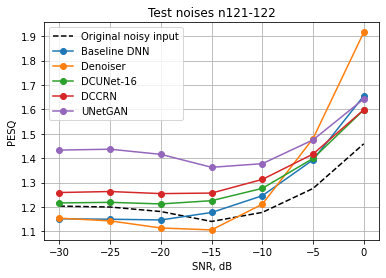

In [15]:
eval_all_and_plot(model_names, speech_dir, te_snr, plot_name='n121-n122-pesq1-v2.pdf')